# Part 1: Model building

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
!pwd

/content


## Downloading Brain Tumor MRI Dataset

In [4]:
!pip install kaggle

In [5]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset --unzip

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 92% 136M/149M [00:01<00:00, 108MB/s]
100% 149M/149M [00:01<00:00, 108MB/s]


In [6]:
def load_image_dataset(base_folder):
    data = []

    # Loop through each class folder in the base directory
    for class_folder in os.listdir(base_folder):
        class_path = os.path.join(base_folder, class_folder)

        # Check if the path is a directory
        if os.path.isdir(class_path):
            # Loop through each image file in the class folder
            for image_file in os.listdir(class_path):
                image_path = os.path.join(class_path, image_file)

                # Append the image path and class label to the data list
                data.append((image_path, class_folder))

    df = pd.DataFrame(data, columns=['image_path', 'class'])
    return df

In [7]:
train_df = load_image_dataset('./Training')
train_df.shape

(5712, 2)

In [8]:
train_df

,image_path,class
0,./Training/meningioma/Tr-me_1245.jpg,meningioma
1,./Training/meningioma/Tr-me_0590.jpg,meningioma
2,./Training/meningioma/Tr-me_0153.jpg,meningioma
3,./Training/meningioma/Tr-me_0130.jpg,meningioma
4,./Training/meningioma/Tr-me_0024.jpg,meningioma
...,...,...
5707,./Training/pituitary/Tr-pi_1392.jpg,pituitary
5708,./Training/pituitary/Tr-pi_1049.jpg,pituitary
5709,./Training/pituitary/Tr-pi_0248.jpg,pituitary
5710,./Training/pituitary/Tr-pi_0790.jpg,pituitary


In [9]:
test_df = load_image_dataset('./Testing')
test_df.shape

(1311, 2)

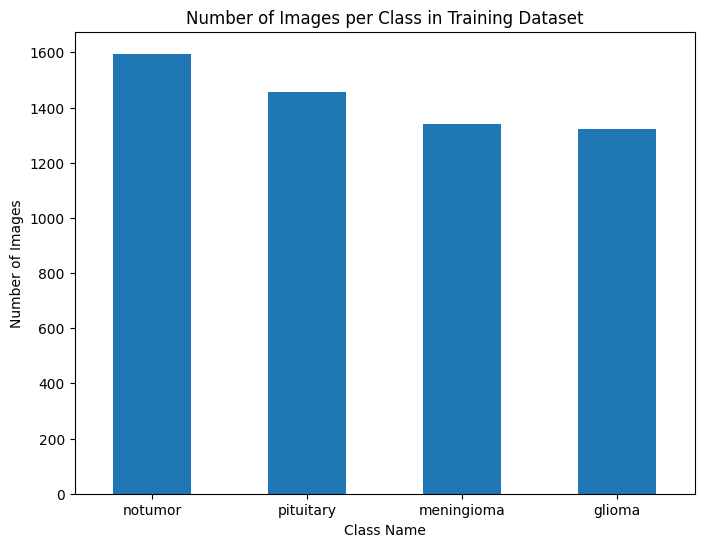

In [10]:
%matplotlib inline

class_counts = train_df['class'].value_counts()

# Plotting the bar chart for training dataset
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar')
plt.title('Number of Images per Class in Training Dataset')
plt.xlabel('Class Name')
plt.ylabel('Number of Images')
plt.xticks(rotation=360)
plt.show()

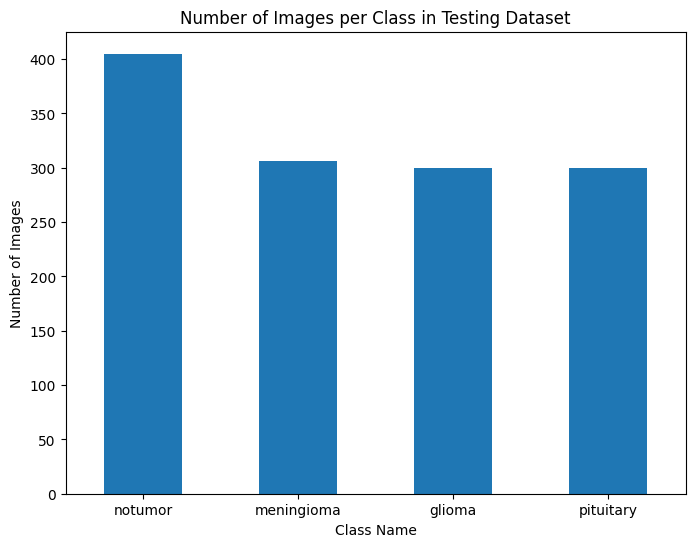

In [11]:
class_counts = test_df['class'].value_counts()

# Plotting the bar chart for testing dataset
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar')
plt.title('Number of Images per Class in Testing Dataset')
plt.xlabel('Class Name')
plt.ylabel('Number of Images')
plt.xticks(rotation=360)
plt.show()

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator



from PIL import Image

In [13]:
val_df, test_df = train_test_split(test_df, test_size=0.5, stratify=test_df['class'], random_state=42)

In [14]:
val_df.shape, test_df.shape

((655, 2), (656, 2))

## Xception Model - Transfer Learning

In [15]:
batch_size = 32

img_size = (299, 299)

# for train and validation data
image_generator = ImageDataGenerator(
    rescale=1/255,
    brightness_range=(0.8, 1.2)
)

# for test data
test_gen = ImageDataGenerator(rescale=1/255)

In [16]:
train_gen = image_generator.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='class',
    batch_size=batch_size,
    target_size=img_size,
    shuffle=True
)

valid_gen = image_generator.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col='class',
    batch_size=batch_size,
    target_size=img_size,
    shuffle=True
)

test_gen = test_gen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='class',
    batch_size=16,
    target_size=img_size,
    shuffle=False
)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


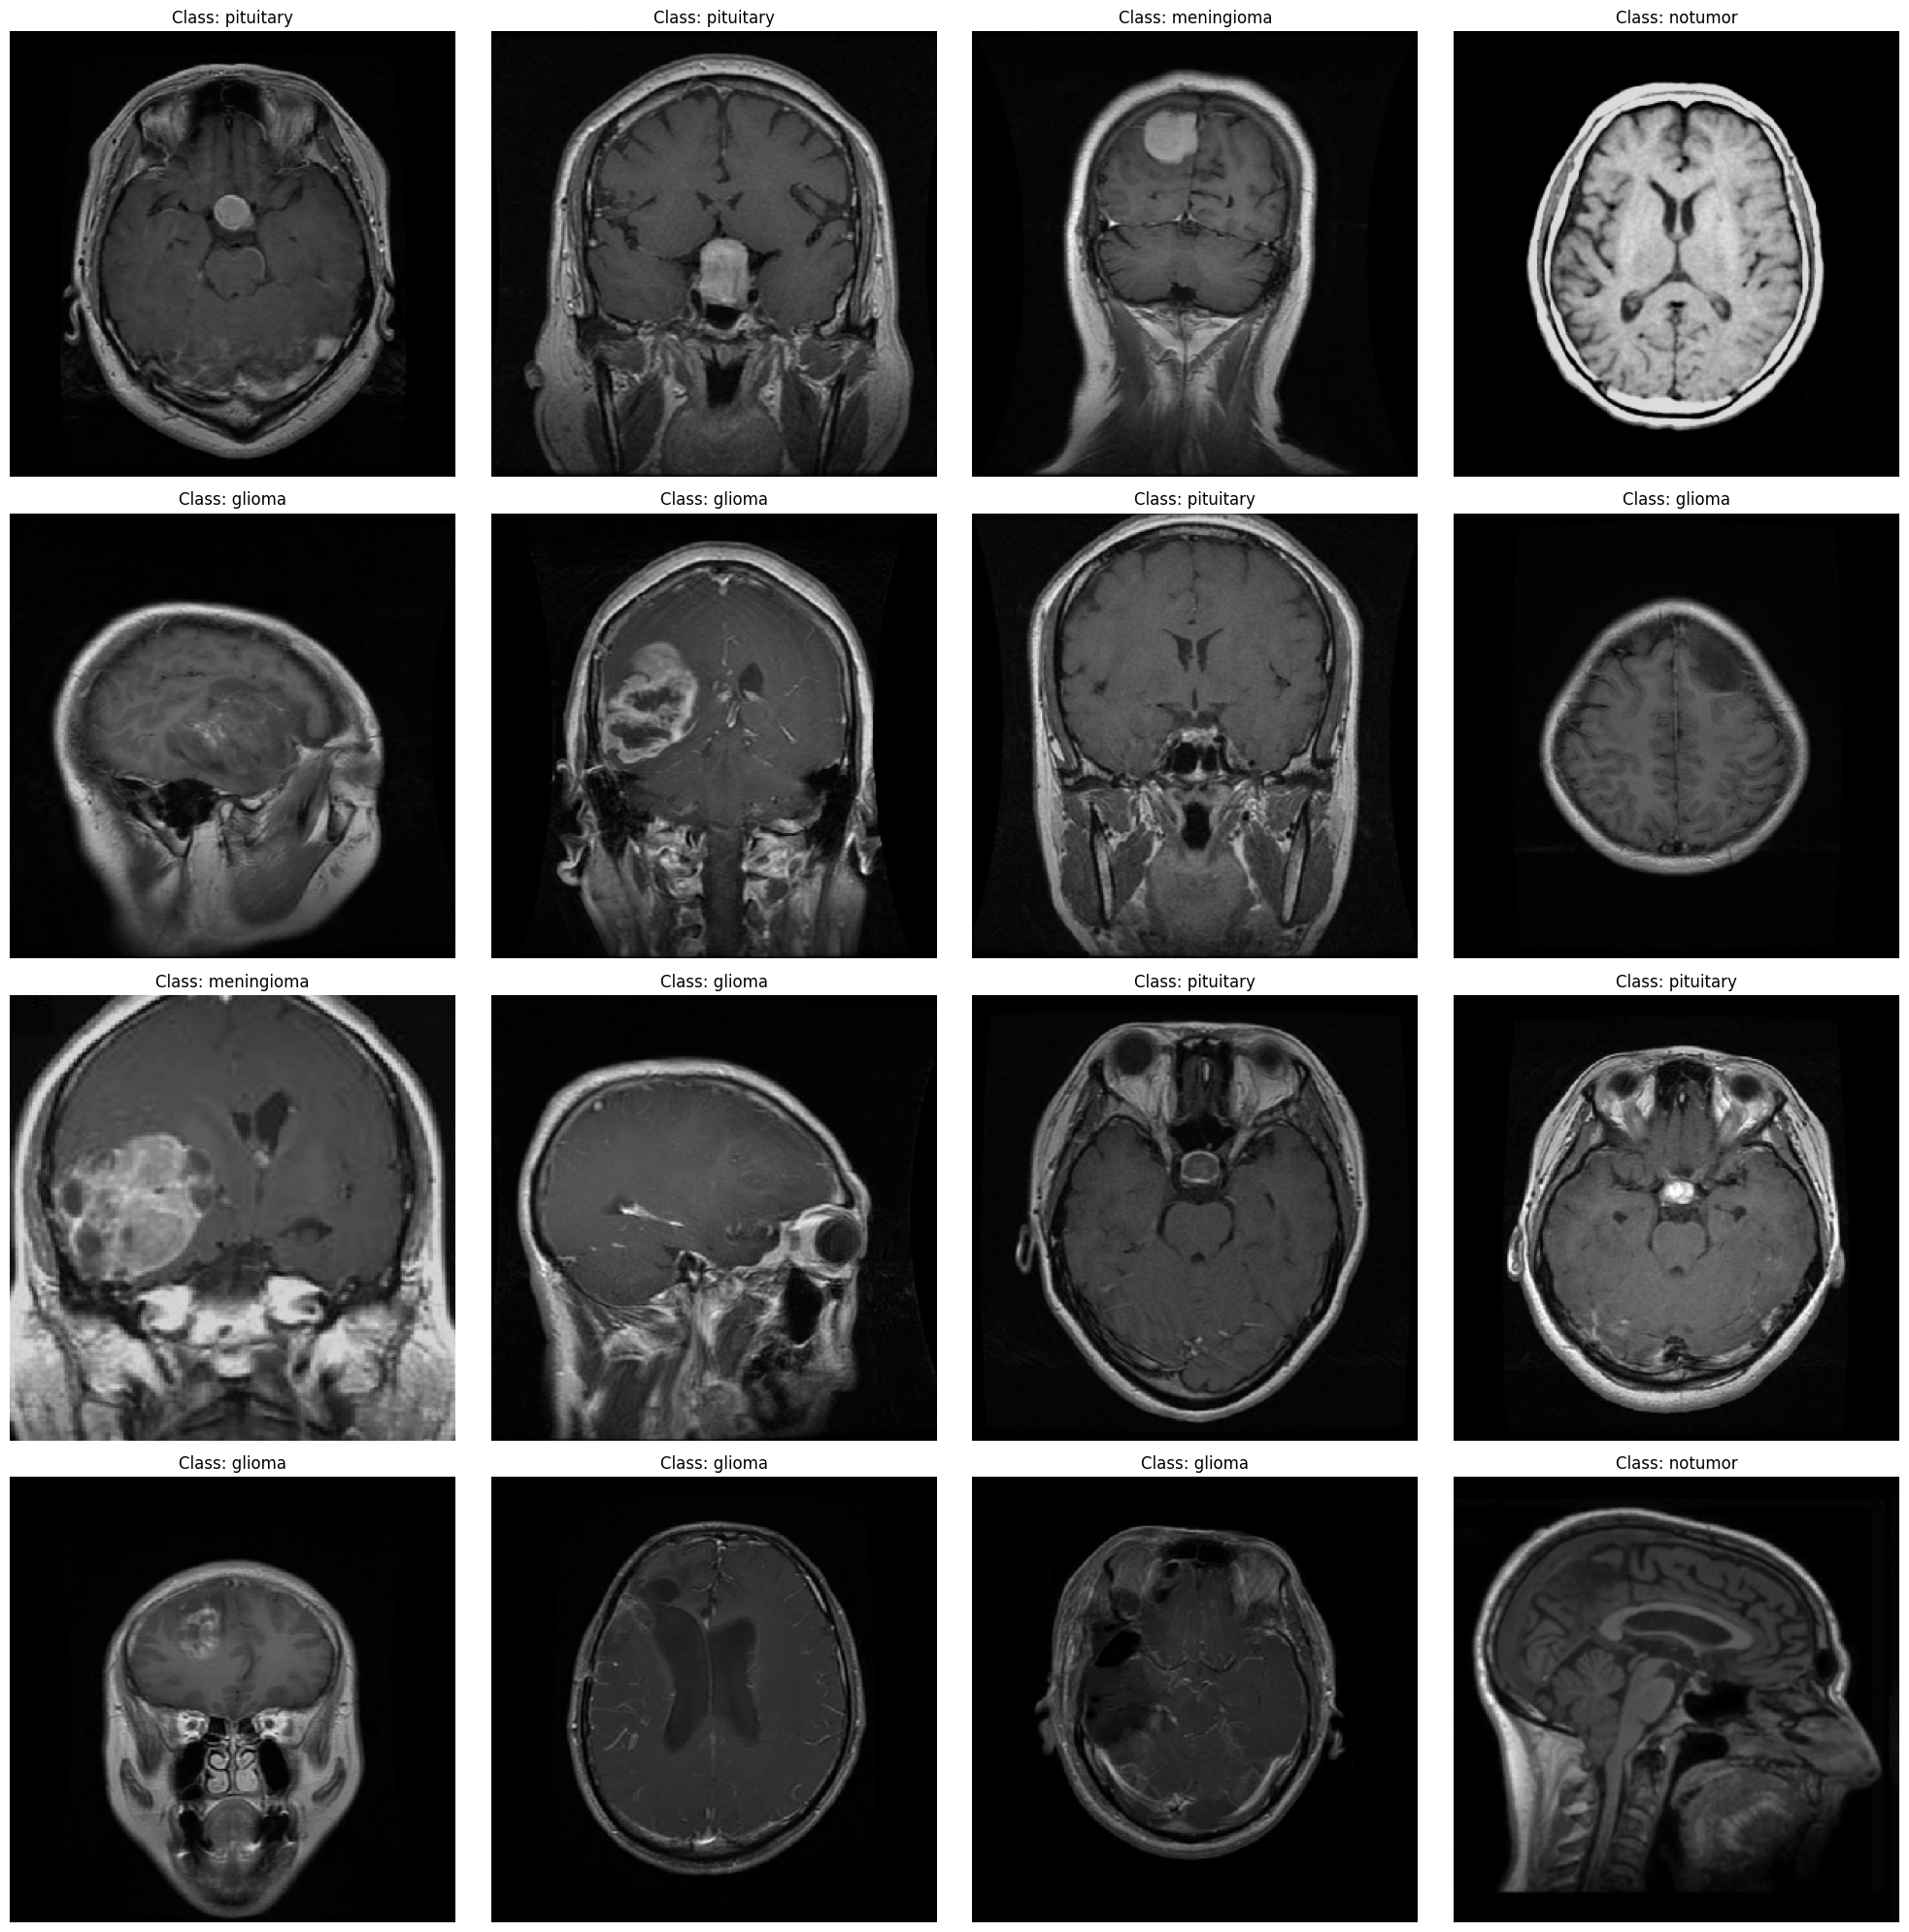

In [17]:
plt.figure(figsize=(20, 20))

for i in range(16):
  plt.subplot(4, 4, i+1)
  batch = next(train_gen)
  image = batch[0][0]
  label = batch[1][0]
  plt.imshow(image)

  # Get the class index
  class_index = np.argmax(label)

  #Get the list of class names and class indices
  class_names = list(train_gen.class_indices.keys())
  class_indices = list(train_gen.class_indices.values())

  # Find the index of the class_index in the list of indices
  index_position = class_indices.index(class_index)

  #Get the class name using the index position
  class_name = class_names[index_position]

  plt.title(f"Class: {class_name}")
  plt.axis('off')

plt.tight_layout()
plt.show()

In [18]:
img_shape = (299, 299, 3)

xception_base_model = tf.keras.applications.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=img_shape,
    pooling='max'
)

model = Sequential([
    xception_base_model,
    Flatten(),
    Dropout(rate=0.3),
    Dense(128, activation='relu'),
    Dropout(rate=0.25),
    Dense(4, activation='softmax')
])

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 2048)                │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,124,268 (80.58 MB)

 Trainable params: 21,069,740 (80.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [20]:
model.compile(
    Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

In [21]:
hist = model.fit(
    train_gen,
    epochs=5,
    validation_data=valid_gen
)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 267s 1s/step - accuracy: 0.8139 - loss: 0.5358 - precision: 0.8693 - recall: 0.7618 - val_accuracy: 0.9466 - val_loss: 0.1541 - val_precision: 0.9523 - val_recall: 0.9450
Epoch 2/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 158s 774ms/step - accuracy: 0.9802 - loss: 0.0614 - precision: 0.9826 - recall: 0.9758 - val_accuracy: 0.9511 - val_loss: 0.1562 - val_precision: 0.9569 - val_recall: 0.9481
Epoch 3/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 145s 801ms/step - accuracy: 0.9881 - loss: 0.0324 - precision: 0.9892 - recall: 0.9880 - val_accuracy: 0.9908 - val_loss: 0.0442 - val_precision: 0.9908 - val_recall: 0.9863
Epoch 4/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 201s 795ms/step - accuracy: 0.9931 - loss: 0.0273 - precision: 0.9936 - recall: 0.9927 - val_accuracy: 0.9924 - val_loss: 0.0358 - val_precision: 0.9924 - val_recall: 0.9924
Epoch 5/5
179/179 ━━━━━━━━━━━━━━━━━━━━ 199s 784ms/step - accuracy: 0.9963 - loss: 0.0176 - precision: 0.9963 - recall: 0.9961 - val_accuracy: 0.9939 - val_loss: 

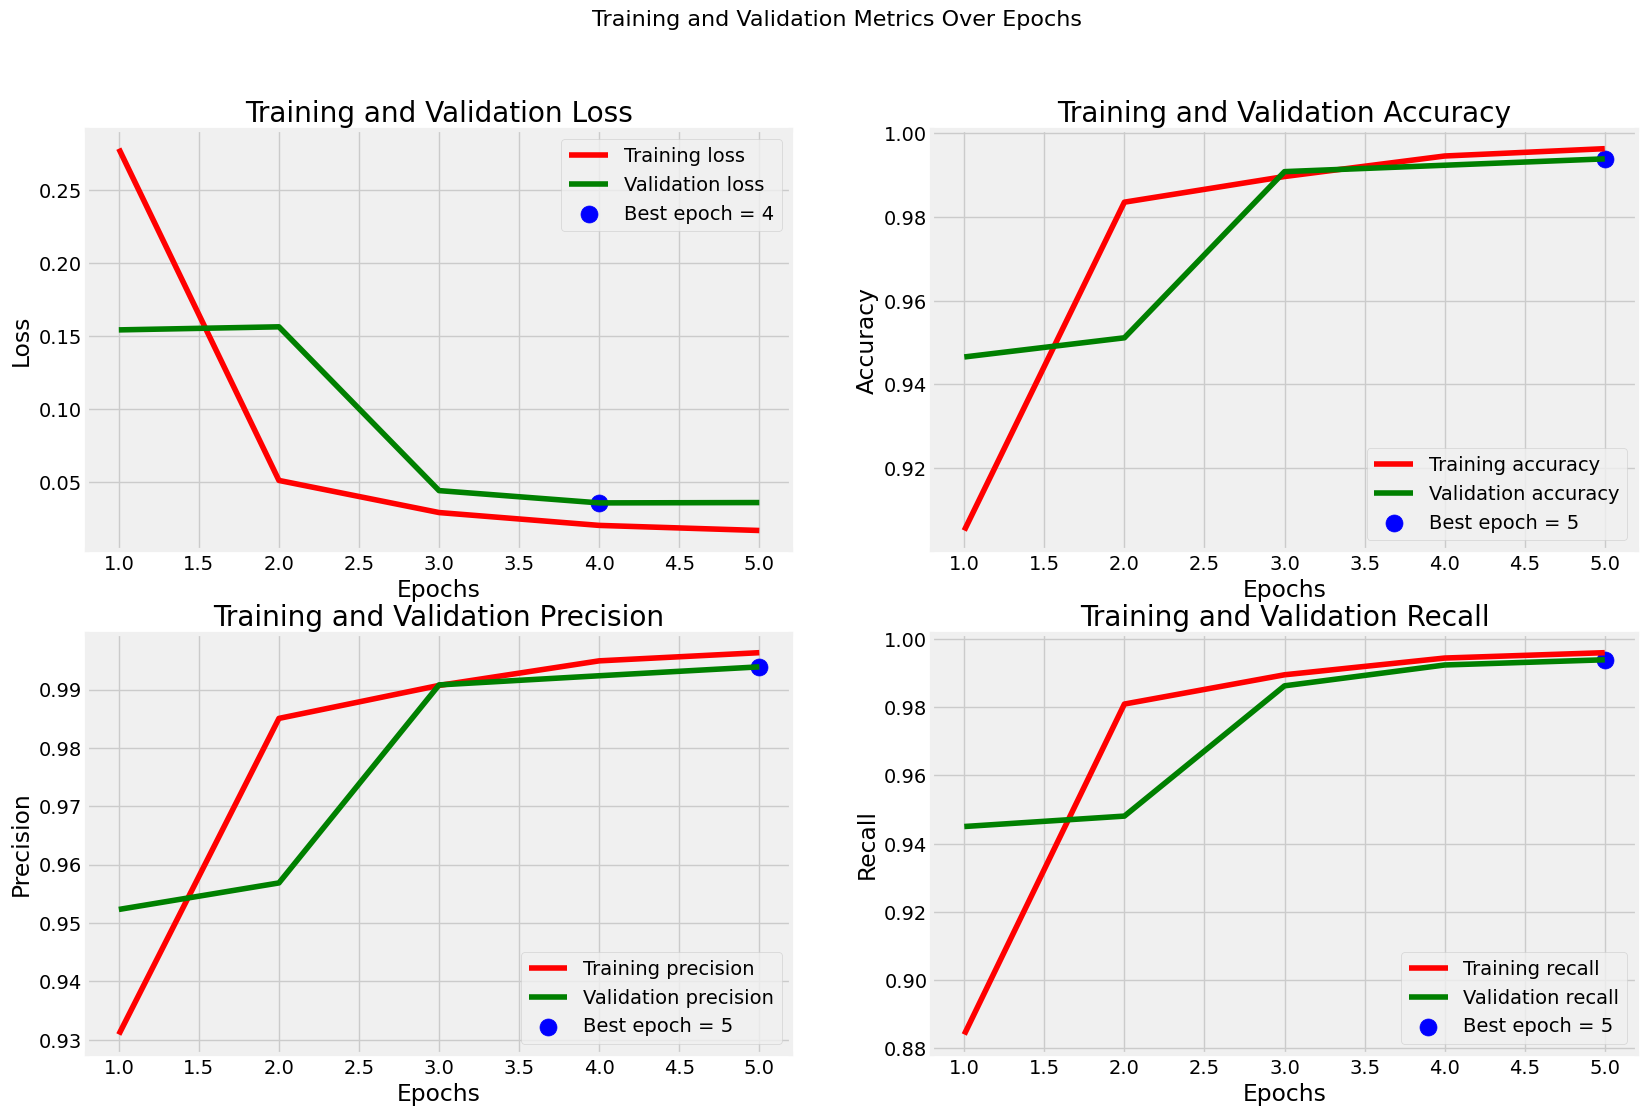

In [22]:
# Get training and validation metrics from history
metrics = ['loss', 'accuracy', 'precision', 'recall']
train_metrics = {m: hist.history[m] for m in metrics}
val_metrics = {m: hist.history[f'val_{m}'] for m in metrics}


# find best epochs and values
best_epochs = {}
best_values = {}
for m in metrics:
  if m == 'loss':
    idx = np.argmin(val_metrics[m])
  else:
    idx = np.argmax(val_metrics[m])
  best_epochs[m] = idx + 1
  best_values[m] = val_metrics[m][idx]


# Plot metrics
plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')

for i, metric in enumerate(metrics, 1):
  plt.subplot(2, 2, i)
  epochs = range(1, len(train_metrics[metric]) + 1)

  plt.plot(epochs, train_metrics[metric], 'r', label=f'Training {metric}')
  plt.plot(epochs, val_metrics[metric], 'g', label=f'Validation {metric}')
  plt.scatter(best_epochs[metric], best_values[metric], s=150, color='blue', label=f'Best epoch = {best_epochs[metric]}')
  plt.title(f'Training and Validation {metric.title()}')
  plt.xlabel('Epochs')
  plt.ylabel(metric.title())
  plt.legend()
  plt.grid(True)


plt.suptitle('Training and Validation Metrics Over Epochs', fontsize=16)
plt.show()

In [23]:
train_score = model.evaluate(train_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(test_gen, verbose=1)


print(f"Train Accuracy: {train_score[1] * 100:.2f}%")
print(f"Train Loss: {train_score[0]:.2f}")
print(f"\n\nValidation Accuracy: {valid_score[1] * 100:.2f}%")
print(f"Validation Loss: {valid_score[0]:.2f}")
print(f"\n\nTest Accuracy: {test_score[1] * 100:.2f}%")
print(f"Test Loss: {test_score[0]:.2f}")

179/179 ━━━━━━━━━━━━━━━━━━━━ 45s 249ms/step - accuracy: 0.9989 - loss: 0.0023 - precision: 0.9991 - recall: 0.9989
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 257ms/step - accuracy: 0.9930 - loss: 0.0354 - precision: 0.9930 - recall: 0.9930
 1/41 ━━━━━━━━━━━━━━━━━━━━ 8s 200ms/step - accuracy: 1.0000 - loss: 7.3066e-04 - precision: 1.0000 - recall: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - accuracy: 0.9955 - loss: 0.0473 - precision: 0.9955 - recall: 0.9950
Train Accuracy: 99.91%
Train Loss: 0.00


Validation Accuracy: 99.08%
Validation Loss: 0.04


Test Accuracy: 99.24%
Test Loss: 0.06


41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step


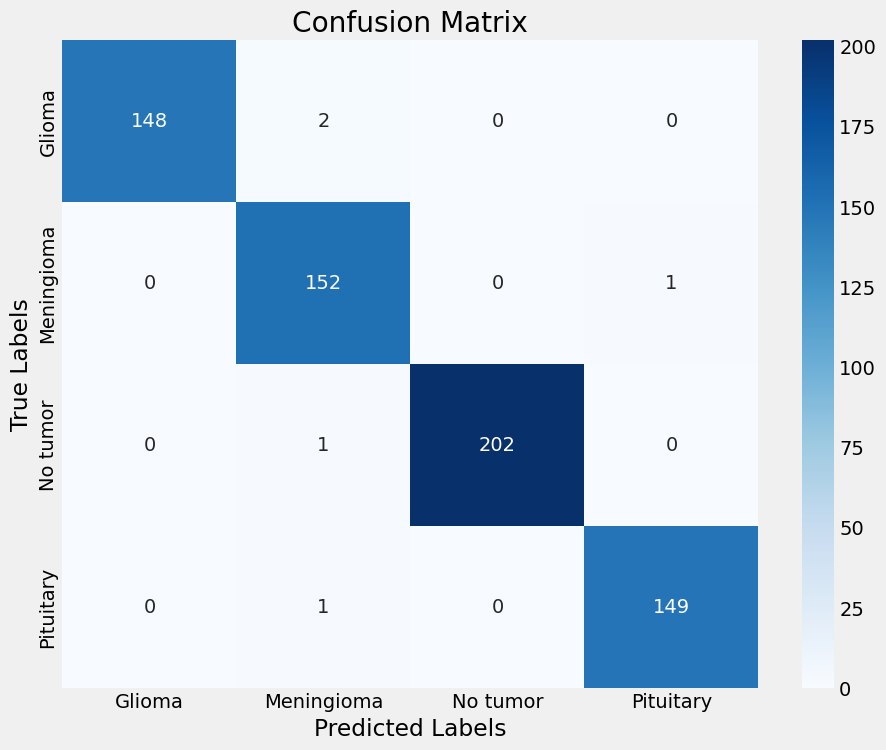

In [24]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

class_dict = {
    0: 'Glioma',
    1: 'Meningioma',
    2: 'No tumor',
    3: 'Pituitary'
}

cm = confusion_matrix(test_gen.classes, y_pred)
labels = list(class_dict.values())

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [29]:
from PIL import Image

def predict(img_path: str) -> None:
  #Get class labels
  labels = list(class_dict.values())

  #Create figure
  plt.figure(figsize=(6,8))

  #Load and preprocess image
  img = Image.open(img_path)
  resized_img = img.resize((299,299))
  img_array = np.asarray(resized_img)
  img_array = np.expand_dims(img_array, axis=0) / 255.0

  #Get model predictions
  predictions = model.predict(img_array)
  probabilities = list(predictions[0])

  #Get predicted class
  predicted_class_idx = np.argmax(probabilities)
  predicted_class = class_dict [predicted_class_idx]

  # Plot original image
  plt.subplot(2, 1, 1)
  plt.imshow(resized_img)
  plt.title(f"Input MRI Image\nPredicted: {predicted_class}")

  # Plot prediction probabilities
  plt.subplot(2, 1, 2)
  bars = plt.barh(labels, probabilities)
  plt.xlabel("Probability", fontsize=15)
  plt.title("Class Probabilities")

  # Add probability labels to bars
  ax = plt.gca()
  ax.bar_label(bars, fmt="%.2f")

  plt.tight_layout()
  plt.show()

  print(f"\nPredicted tumor type: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


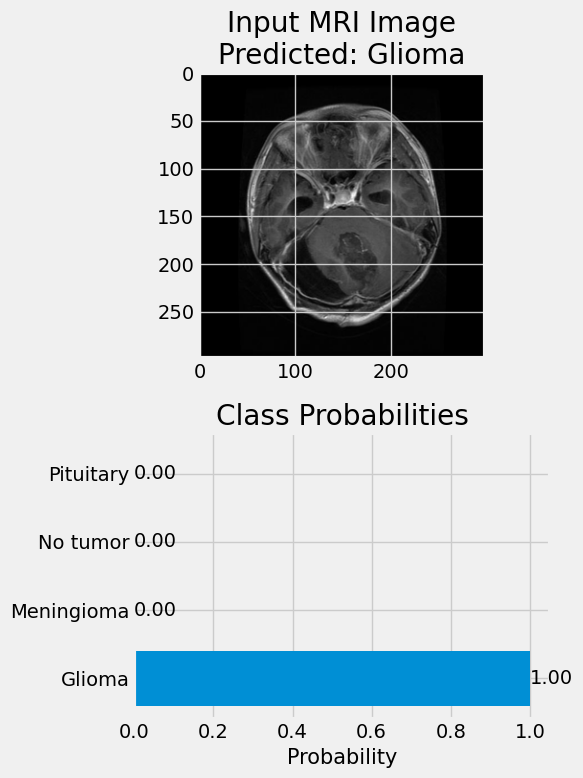


Predicted tumor type: Glioma


In [30]:
predict('./Testing/glioma/Te-glTr_0000.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


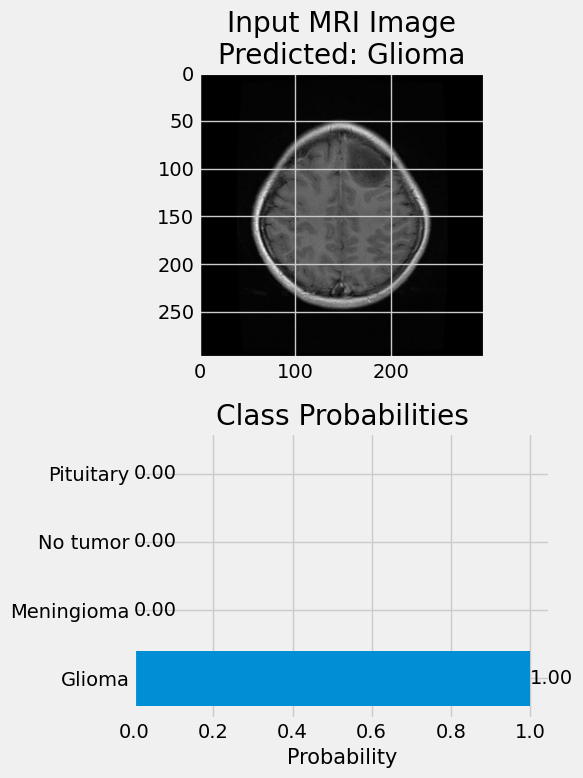


Predicted tumor type: Glioma


In [31]:
predict('./Testing/glioma/Te-glTr_0005.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


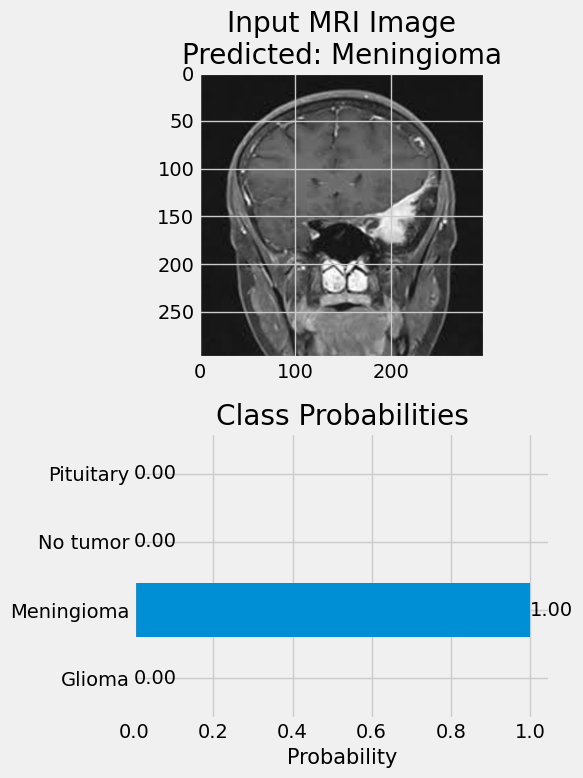


Predicted tumor type: Meningioma


In [32]:
predict('./Testing/meningioma/Te-meTr_0003.jpg')

In [33]:
model.save_weights('xception_model_weights.weights.h5')

In [55]:
model.save('xception_model.h5')

## Custom CNN model

In [34]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers

In [35]:
batch_size = 16

img_size = (224, 224)

# for train and validation data
image_generator = ImageDataGenerator(
    rescale=1/255,
    brightness_range=(0.8, 1.2)
)

# for test data
test_gen = ImageDataGenerator(rescale=1/255)

In [36]:
train_gen = image_generator.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='class',
    batch_size=batch_size,
    target_size=img_size,
    shuffle=True
)

valid_gen = image_generator.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col='class',
    batch_size=batch_size,
    target_size=img_size,
    shuffle=True
)

test_gen = test_gen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='class',
    batch_size=16,
    target_size=img_size,
    shuffle=False
)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


In [39]:
# Custom CNN model

cnn_model = Sequential()

# Convolutional layers with ReLU activation and pooling
cnn_model.add(Conv2D(1024, kernel_size=3, padding='same', activation='relu', input_shape=(224, 224, 3)))
cnn_model.add(MaxPooling2D(pool_size=2, strides=2))

cnn_model.add(Conv2D(512, kernel_size=3, padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=2, strides=2))

cnn_model.add(Conv2D(256, kernel_size=3, padding='same', activation='relu'))
cnn_model.add(Conv2D(128, kernel_size=3, padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=2, strides=2))

cnn_model.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=2, strides=2))

# Flatten and fully connected layers
cnn_model.add(Flatten())
cnn_model.add(Dense(256, activation='relu'))
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dense(4, activation='softmax'))

# Print the model summary
cnn_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)                   │ (None, 224, 224, 1024)      │          28,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 112, 112, 1024)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 112, 112, 512)       │       4,719,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 56, 56, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 56, 56, 256)         │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 56, 56, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 28, 28, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │       3,211,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,541,444 (36.40 MB)

 Trainable params: 9,541,444 (36.40 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
cnn_model.compile(
    Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

In [41]:
hist = cnn_model.fit(
    train_gen,
    epochs=5,
    validation_data=valid_gen
)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


357/357 ━━━━━━━━━━━━━━━━━━━━ 439s 1s/step - accuracy: 0.5637 - loss: 0.9790 - precision_1: 0.6978 - recall_1: 0.3944 - val_accuracy: 0.7588 - val_loss: 0.5741 - val_precision_1: 0.7818 - val_recall_1: 0.7221
Epoch 2/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 316s 868ms/step - accuracy: 0.8196 - loss: 0.4425 - precision_1: 0.8368 - recall_1: 0.7933 - val_accuracy: 0.7893 - val_loss: 0.5377 - val_precision_1: 0.8112 - val_recall_1: 0.7740
Epoch 3/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 313s 874ms/step - accuracy: 0.8843 - loss: 0.2986 - precision_1: 0.8994 - recall_1: 0.8738 - val_accuracy: 0.8977 - val_loss: 0.2800 - val_precision_1: 0.9152 - val_recall_1: 0.8901
Epoch 4/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 311s 869ms/step - accuracy: 0.9374 - loss: 0.1842 - precision_1: 0.9410 - recall_1: 0.9334 - val_accuracy: 0.9298 - val_loss: 0.1761 - val_precision_1: 0.9339 - val_recall_1: 0.9282
Epoch 5/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 322s 870ms/step - accuracy: 0.9619 - loss: 0.1186 - precision_1: 0.9637 - recall_1: 0.9601

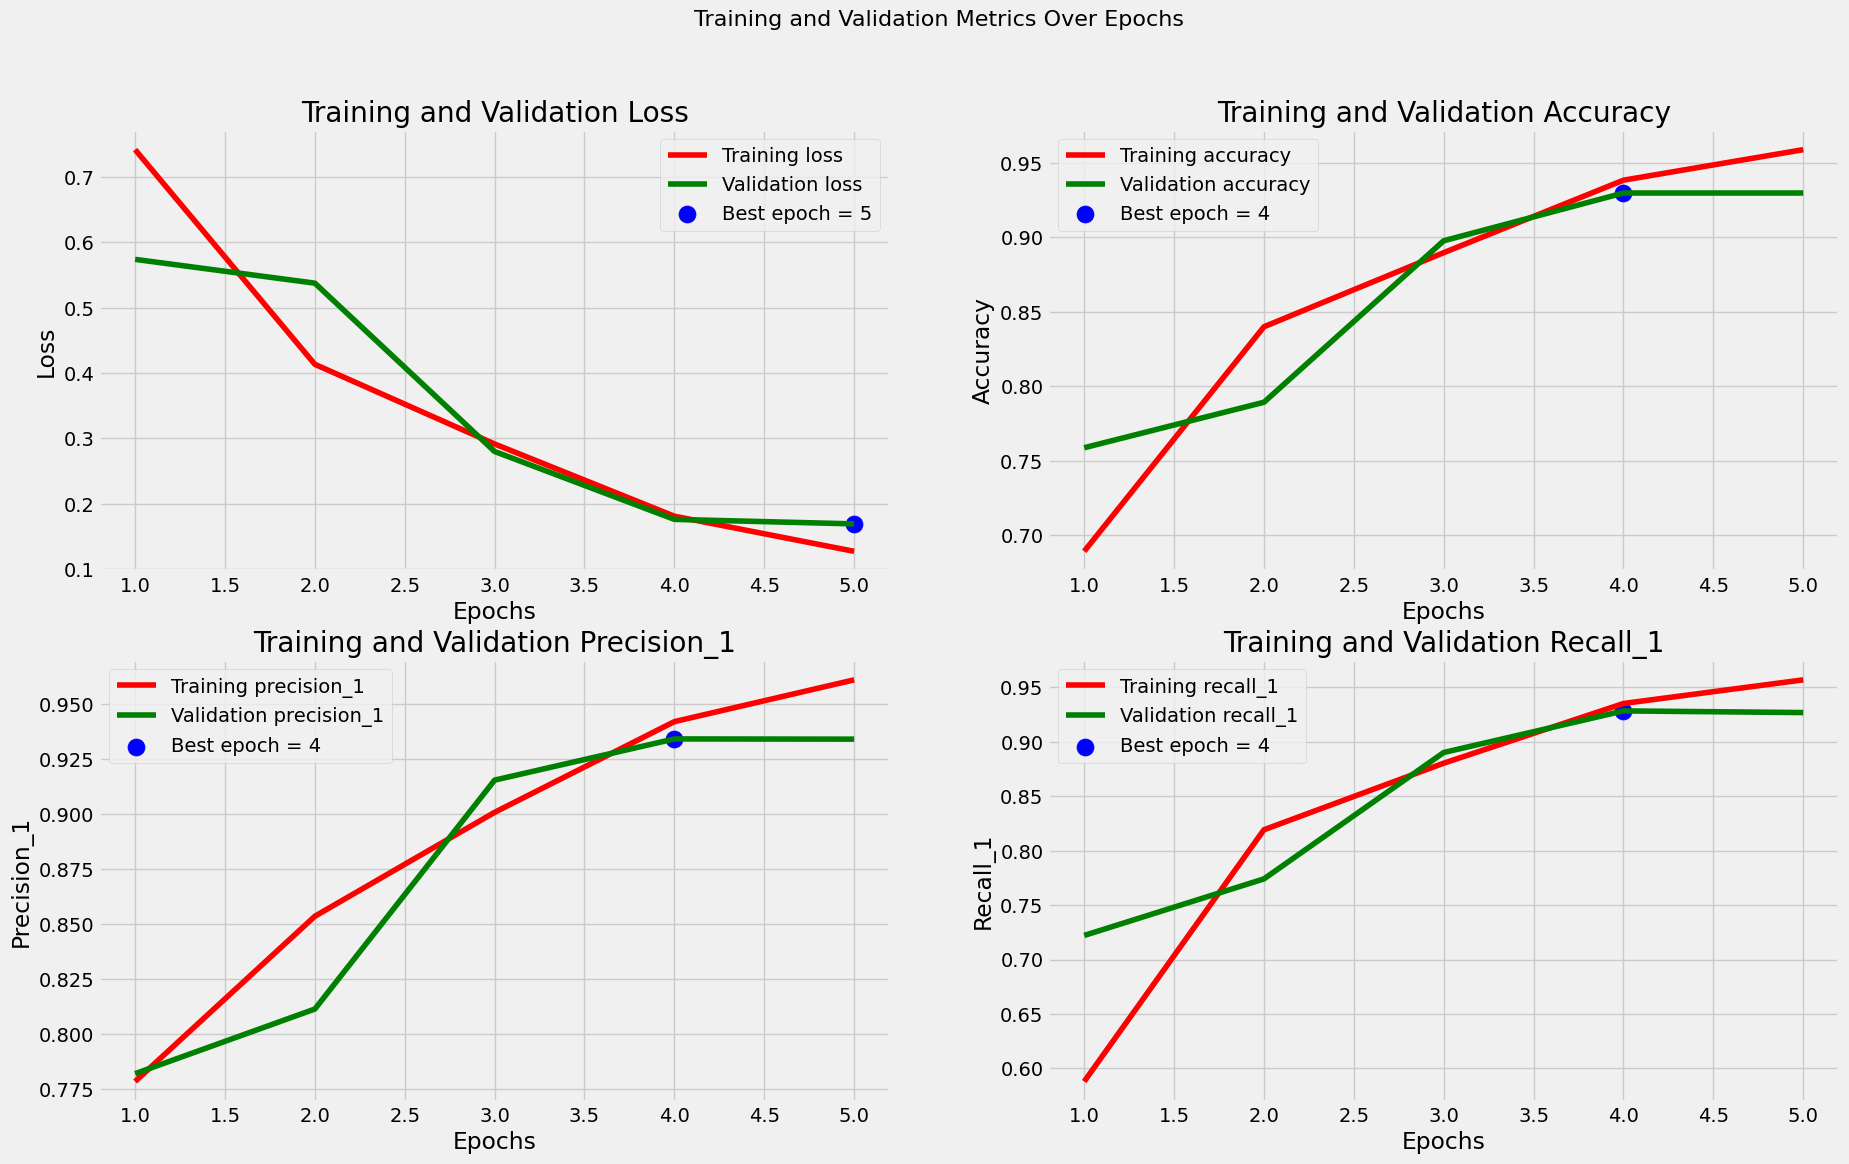

In [48]:
# Get training and validation metrics from history
metrics = ['loss', 'accuracy', 'precision_1', 'recall_1']
train_metrics = {m: hist.history[m] for m in metrics}
val_metrics = {m: hist.history[f'val_{m}'] for m in metrics}


# find best epochs and values
best_epochs = {}
best_values = {}
for m in metrics:
  if m == 'loss':
    idx = np.argmin(val_metrics[m])
  else:
    idx = np.argmax(val_metrics[m])
  best_epochs[m] = idx + 1
  best_values[m] = val_metrics[m][idx]


# Plot metrics
plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')

for i, metric in enumerate(metrics, 1):
  plt.subplot(2, 2, i)
  epochs = range(1, len(train_metrics[metric]) + 1)

  plt.plot(epochs, train_metrics[metric], 'r', label=f'Training {metric}')
  plt.plot(epochs, val_metrics[metric], 'g', label=f'Validation {metric}')
  plt.scatter(best_epochs[metric], best_values[metric], s=150, color='blue', label=f'Best epoch = {best_epochs[metric]}')
  plt.title(f'Training and Validation {metric.title()}')
  plt.xlabel('Epochs')
  plt.ylabel(metric.title())
  plt.legend()
  plt.grid(True)


plt.suptitle('Training and Validation Metrics Over Epochs', fontsize=16)
plt.show()

In [49]:
train_score = cnn_model.evaluate(train_gen, verbose=1)
valid_score = cnn_model.evaluate(valid_gen, verbose=1)
test_score = cnn_model.evaluate(test_gen, verbose=1)


print(f"Train Accuracy: {train_score[1] * 100:.2f}%")
print(f"Train Loss: {train_score[0]:.2f}")
print(f"\n\nValidation Accuracy: {valid_score[1] * 100:.2f}%")
print(f"Validation Loss: {valid_score[0]:.2f}")
print(f"\n\nTest Accuracy: {test_score[1] * 100:.2f}%")
print(f"Test Loss: {test_score[0]:.2f}")

357/357 ━━━━━━━━━━━━━━━━━━━━ 71s 199ms/step - accuracy: 0.9704 - loss: 0.0909 - precision_1: 0.9714 - recall_1: 0.9691
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 195ms/step - accuracy: 0.9207 - loss: 0.1528 - precision_1: 0.9365 - recall_1: 0.9197


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 194ms/step - accuracy: 0.9084 - loss: 0.2446 - precision_1: 0.9086 - recall_1: 0.9029
Train Accuracy: 96.97%
Train Loss: 0.09


Validation Accuracy: 92.67%
Validation Loss: 0.17


Test Accuracy: 92.38%
Test Loss: 0.21


41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step


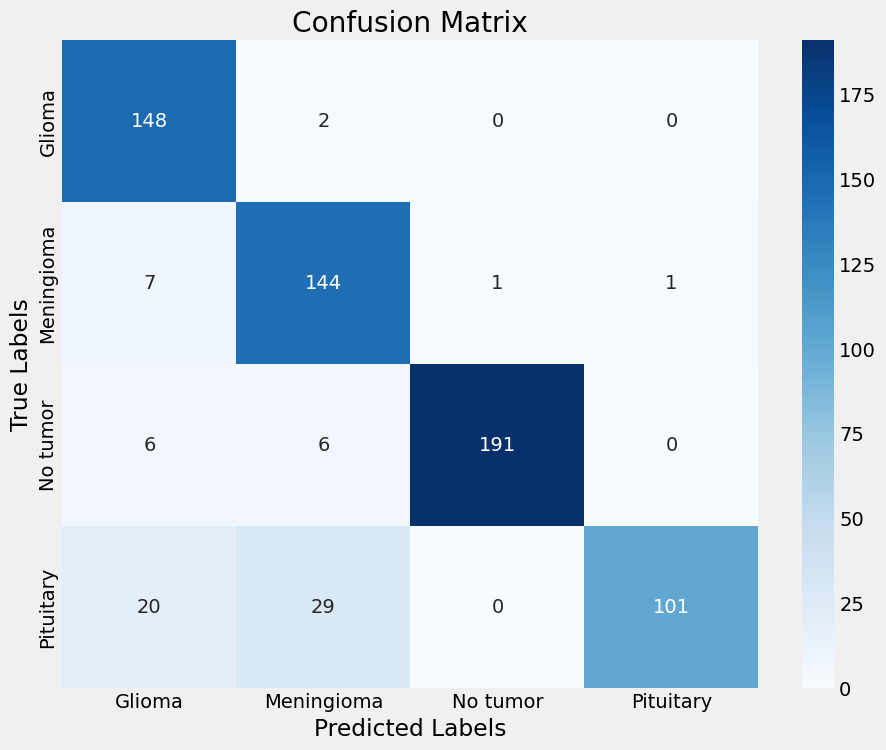

In [50]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

class_dict = {
    0: 'Glioma',
    1: 'Meningioma',
    2: 'No tumor',
    3: 'Pituitary'
}

cm = confusion_matrix(test_gen.classes, y_pred)
labels = list(class_dict.values())

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [51]:
clr = classification_report(test_gen.classes, y_pred, target_names=labels)
print(clr)

              precision    recall  f1-score   support

      Glioma       0.82      0.99      0.89       150
  Meningioma       0.80      0.94      0.86       153
    No tumor       0.99      0.94      0.97       203
   Pituitary       0.99      0.67      0.80       150

    accuracy                           0.89       656
   macro avg       0.90      0.89      0.88       656
weighted avg       0.91      0.89      0.89       656



In [54]:
cnn_model.save('cnn_model.h5')